# Tabular claasification: AIX360

In this notebook, we examine the explanation methods in AIX360 applied to three models: Logistic regression, Random Forest, and MLP.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


2024-06-25 14:48:47.111983: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 14:48:47.116384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/cudnnv895/lib:/usr/local/cuda/cudnnv895/include:/usr/local/cuda/lib64:/usr/local/cuda/cudnnv895/lib:/usr/local/cuda/cudnnv895/include:/usr/local/cuda/lib64:
2024-06-25 14:48:47.116403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please up

Load data, define veriale names, split into train/valid/test

In [3]:
data = pd.read_csv("/home/kxlu/Documents/xai_compare/data/fraud/creditcard.csv")
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

# split data into train, validation, and test
train_df, test_df = train_test_split(data, train_size=0.80, random_state=42,shuffle=True)

X_train = train_df[predictors]
X_test = test_df[predictors]
train_labels = train_df[target]
test_labels = test_df[target]
# normalize data
X_train=(X_train-X_train.mean())/X_train.std()
X_test=(X_test-X_test.mean())/X_test.std()
# X_train.index = train_df.index
# X_test.index = test_df.index

Build logistic regression

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, train_labels)

LogisticRegression()

Build random forest

In [5]:
clf = RandomForestClassifier(n_jobs=5, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)
clf.fit(X_train, train_labels)

RandomForestClassifier(n_jobs=5, random_state=42, verbose=False)

Build MLP using tf

In [6]:
from tensorflow.keras import regularizers
model = tf.keras.Sequential(
    [
        # Adjusted number of neurons
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[-1],),
                              kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        tf.keras.layers.Dropout(0.2),  # Adjusted dropout rate
        tf.keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        tf.keras.layers.Dropout(0.2),  # Adjusted dropout rate
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


2024-06-25 14:49:40.986060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/cudnnv895/lib:/usr/local/cuda/cudnnv895/include:/usr/local/cuda/lib64:/usr/local/cuda/cudnnv895/lib:/usr/local/cuda/cudnnv895/include:/usr/local/cuda/lib64:
2024-06-25 14:49:40.986314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/cudnnv895/lib:/usr/local/cuda/cudnnv895/include:/usr/local/cuda/lib64:/usr/local/cuda/cudnnv895/lib:/usr/local/cuda/cudnnv895/include:/usr/local/cuda/lib64:
2024-06-25 14:49:40.986492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublas

In [7]:
metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = metrics)

# calculate class weights
neg, pos = np.bincount(train_labels.astype("int64"))
total = neg + pos
class_weight = {1: 1, 2: 5}

# train the model
history = model.fit(X_train, train_labels,epochs=5)

Epoch 1/5
7121/7121 [==============================] - 30s 4ms/step - loss: 0.1045 - fn: 222.0000 - fp: 1480.0000 - tn: 225971.0000 - tp: 172.0000 - precision: 0.1041 - recall: 0.4365
Epoch 2/5
7121/7121 [==============================] - 29s 4ms/step - loss: 0.0154 - fn: 116.0000 - fp: 42.0000 - tn: 227409.0000 - tp: 278.0000 - precision: 0.8687 - recall: 0.7056
Epoch 3/5
7121/7121 [==============================] - 28s 4ms/step - loss: 0.0060 - fn: 107.0000 - fp: 42.0000 - tn: 227409.0000 - tp: 287.0000 - precision: 0.8723 - recall: 0.7284
Epoch 4/5
7121/7121 [==============================] - 27s 4ms/step - loss: 0.0046 - fn: 106.0000 - fp: 41.0000 - tn: 227410.0000 - tp: 288.0000 - precision: 0.8754 - recall: 0.7310
Epoch 5/5
7121/7121 [==============================] - 29s 4ms/step - loss: 0.0044 - fn: 103.0000 - fp: 41.0000 - tn: 227410.0000 - tp: 291.0000 - precision: 0.8765 - recall: 0.7386


NN Contrastive (model free)

In [8]:
from aix360.algorithms.nncontrastive import NearestNeighborContrastiveExplainer
epochs = 500
embedding_dim = 4
layers_config = []
random_seed = 1 # to have consistent resutls for demos
neighbors = 5 # number of explanations to be returned

explainer = NearestNeighborContrastiveExplainer(embedding_dim=embedding_dim, layers_config=layers_config, neighbors=neighbors)
benign_exemplars = X_train.iloc[np.where(train_labels == 1)[0], :] ## Examples with pred target = 1
malignant_exemplars = X_train.iloc[np.where(train_labels == 0)[0], :] ## Examples with pred target = 0

history = explainer.fit(
    X_train,
    epochs=epochs,
    numeric_scaling=None,
    exemplars=benign_exemplars,
    random_seed=random_seed,
)

p_str = f'Epochs: {epochs}'
for key in history.history:
    p_str = f'{p_str}\t{key}: {history.history[key][-1]:.4f}'
print(p_str)

13/13 [==============================] - 0s 792us/step
Epochs: 500	loss: 0.7842


In [9]:
# select a random sample with label 0
malignant_predictions_indices = np.where(test_labels == 0)[0]
rand_index = np.random.choice(malignant_predictions_indices)
sample_malignant_cell = X_test.iloc[rand_index:rand_index+1]
sample_malignant_cell

# compute nearest benign cell
nearest_benign_cell = explainer.explain_instance(sample_malignant_cell)
print('nearest_benign_cell:', nearest_benign_cell[0]["neighbors"][0])

# compute nearest malignant cell
explainer.set_exemplars(malignant_exemplars)
nearest_malignant_cell = explainer.explain_instance(sample_malignant_cell)
print('nearest_malignant_cell:',nearest_malignant_cell[0]["neighbors"][0])

1/1 [==============================] - 0s 22ms/step
nearest_benign_cell: [-0.3383463630330191, -2.2025800059972847, 1.1389938393276704, -1.5435085386713816, -0.3346283440704068, -0.8549891101225686, -1.5794886709563416, -1.7079977811094578, 0.22963039387520046, 0.26359691556029985, -3.5268585073893592, 2.457282191298393, -3.603613397220433, -1.029072619585961, -5.515548590787088, 1.8050082234632048, -3.719340120155662, -5.088858771653685, -2.2227160968378086, -0.011846179162914045, -0.9290202682253738, 0.7511775999410724, -0.09189820279984309, -1.7778034144494803, 0.44477372644067625, -0.03755180056193778, -1.9967053689559024, -2.2867323545119906, 0.0036273169349388505, -0.11171679289017004]
 348/7108 [>.............................] - ETA: 4s

1/1 [==============================] - 0s 23ms/step
nearest_malignant_cell: [-0.21532703233280087, 0.6255722481456291, -0.33162352737051604, 0.49646404426369345, -0.6349326073366708, -0.8395009100687522, -0.26571290070807485, -0.6565013600246612, 0.2075052557007199, 1.7124887065489707, -0.7839016421691977, 0.6150344627751948, 0.28117996252159394, -2.031136739346141, 0.434385944583139, 0.8867692468803057, -0.06586070217166343, -0.47651971072748406, 1.231529641273096, 1.2088031870669318, -0.29646973436501795, -0.00718480001778014, 0.14680480204868426, -0.10535300389531581, -0.05223832782039115, 0.8614129083971809, -1.4024601597013133, 0.19075142004796639, 0.05239653486322737, -0.3431526220999165]


The below code are from the examples in AIX360 GitHub. There is no built-in visualization tools.

In [10]:
import matplotlib.pyplot as plt
def plot_matrix(matrix, vmin=None, vmax=None, precision=3, rotation=0):
    if len(matrix.shape) == 1:
        matrix = matrix[np.newaxis, :]

    if vmin is None:
        vmin = np.min(matrix)
    if vmax is None:
        vmax = np.max(matrix)

    fig, ax = plt.subplots(figsize=(20, 4))
    ax_mat = ax.matshow(matrix, vmin=vmin, vmax=vmax, aspect="auto", cmap="RdYlGn")
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            c = matrix[i, j]
            ax.text(
                j,
                i,
                str(np.round(c, precision)),
                va="center",
                ha="center",
                rotation=rotation,
                color="black",
                fontweight="bold",
                fontsize="x-large",
            )
    fig.colorbar(ax_mat, ax = ax)

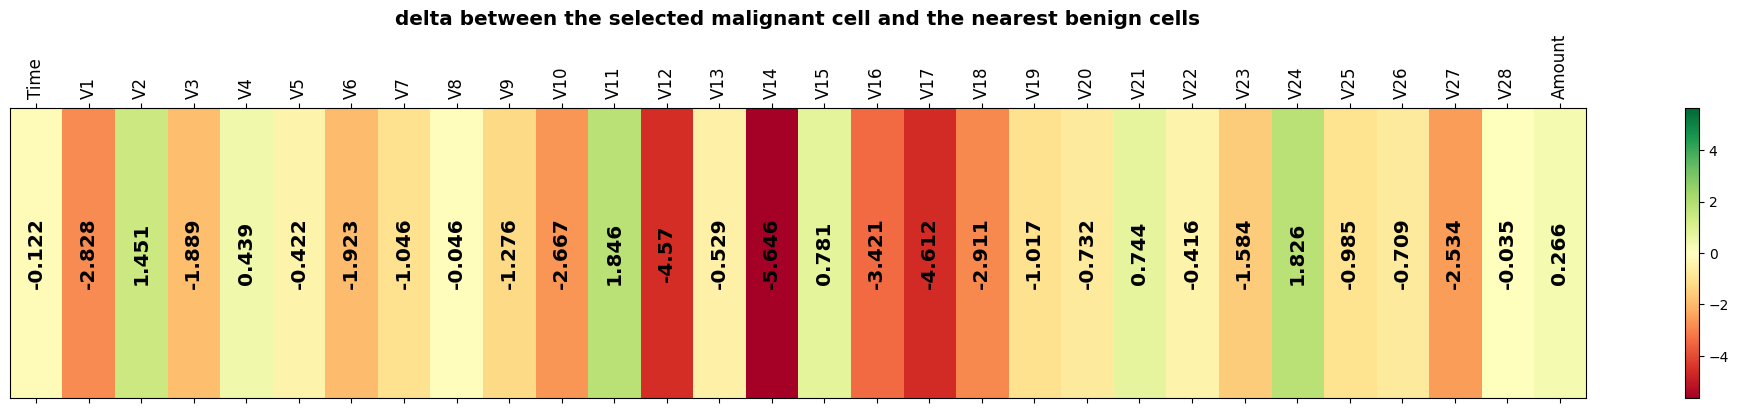

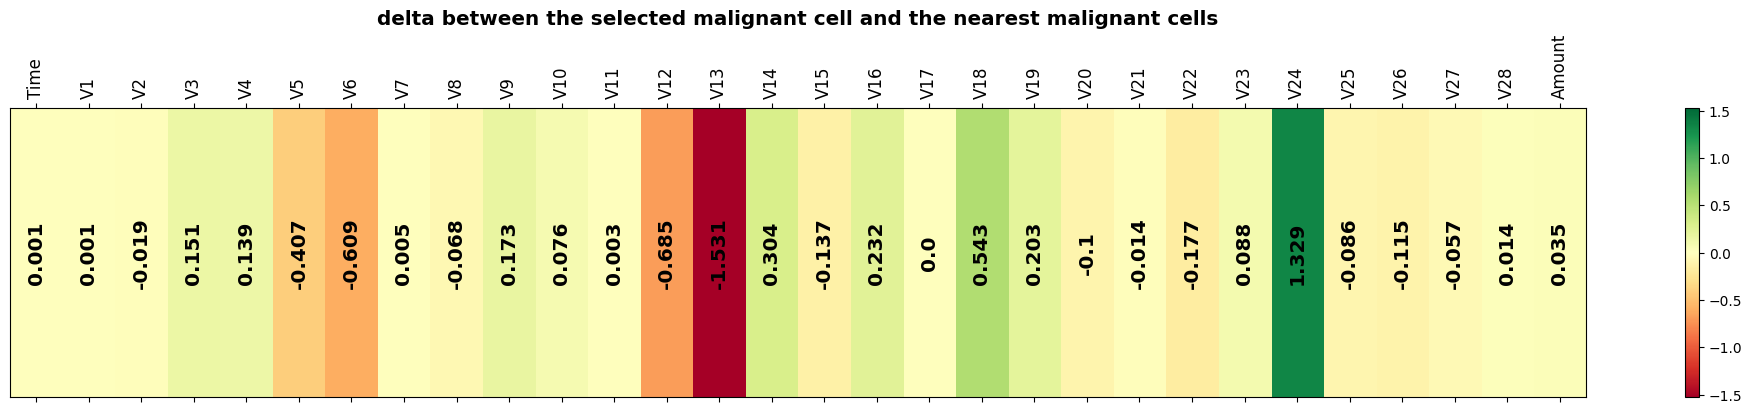

In [11]:
delta = np.array(nearest_benign_cell[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(predictors)), predictors,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest benign cells', fontsize='x-large', fontweight='bold')
plt.show()

delta = np.array(nearest_malignant_cell[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(predictors)), predictors,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest malignant cells', fontsize='x-large', fontweight='bold')
plt.show()

### Logistic regression

In [12]:
from aix360.algorithms.shap import KernelExplainer
idx = np.random.randint(X_train.shape[0],size=10000)
shapexplainer = KernelExplainer(lr.predict_proba, X_train.iloc[idx,:])
print(type(shapexplainer))

# aix360 style for explaining input instances
shap_values = shapexplainer.explain_instance(X_test.iloc[0,:])
for _ in zip(X_test.columns,shap_values[:,0]):
    print(_)

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<class 'aix360.algorithms.shap.shap_wrapper.KernelExplainer'>
('Time', -0.020687002260896616)
('V1', 0.07235752809428651)
('V2', 0.0)
('V3', -0.02545788732179344)
('V4', -0.21016049975221532)
('V5', 0.05960325764557018)
('V6', -0.006991028402674473)
('V7', -0.0825633209908102)
('V8', 0.027066781529350138)
('V9', -0.08105756327252103)
('V10', -0.4135733916319685)
('V11', 0.027817328933164822)
('V12', 0.018232362560987207)
('V13', 0.01739661294629298)
('V14', -0.18699845437746893)
('V15', 0.008677005533540482)
('V16', -0.05038724792331353)
('V17', -0.025735108193549797)
('V18', 0.009171993031533453)
('V19', 0.0)
('V20', -0.03161412020639119)
('V21', -0.01967367290082479)
('V22', 0.017227919078163463)
('V23', -0.010276220113543892)
('V24', 0.0)
('V25', -0.014397163040984701)
('V26', -0.002905926372338741)
('V27', -0.06725487863282952)
('V28', -0.005883462845260867)
('Amount', 0.0)


In [13]:
from aix360.algorithms.lime import LimeTabularExplainer
limeexplainer = LimeTabularExplainer(X_train.iloc[idx,:].values)
explanattion = limeexplainer.explain_instance(X_test.iloc[0,:].values,lr.predict_proba)
print ('Explanation for class 0')
print ('\n'.join(map(str, explanattion.as_list())))

Explanation for class 0
('4 > 0.56', 0.004164074430839422)
('10 <= -0.47', 0.0035678849161965144)
('14 <= -0.45', 0.003341599273802397)
('0 <= -0.86', 0.0024319279586809414)
('21 > 0.24', 0.002285217761281152)
('27 <= -0.17', 0.0021972452042703407)
('20 <= -0.27', 0.0021050864943076768)
('25 <= -0.60', 0.0020961174652744967)
('23 <= -0.25', 0.0019679596615474874)
('7 <= -0.45', 0.0019370106428416144)


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


NN Contrastive

In [14]:
neighbors = 3
explainer_with_model = NearestNeighborContrastiveExplainer(model=lr.predict,
                                              embedding_dim=embedding_dim,
                                              layers_config=layers_config,
                                              neighbors=neighbors)

history = explainer_with_model.fit(
    X_train,
    epochs=epochs,
    numeric_scaling=None,
    random_seed=random_seed,
)

p_str = f'Epochs: {epochs}'
for key in history.history:
    p_str = f'{p_str}\t{key}: {history.history[key][-1]:.4f}'
print(p_str)

Epochs: 500	loss: 0.7832


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [15]:
# find nearest benign contrastive
explainer_with_model.set_exemplars(malignant_exemplars)
nearest_benign_contrastive = explainer_with_model.explain_instance(sample_malignant_cell)
nearest_benign_contrastive[0]["neighbors"][0]

delta = np.array(nearest_benign_contrastive[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(predictors)), predictors,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest benign contrastive', fontsize='x-large', fontweight='bold')
plt.show()

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


IndexError: list index out of range

Individual conditional expectation

The code below for visualization are copied from AIX360 GitHub.

In [16]:
from typing import List, Union, Tuple
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np

def plot_ice_explanation(explanation, title):
    feature_names = list(explanation.keys())
    
    fig = plt.figure(layout='constrained', figsize=(15,10))
    gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios= [1, int(len(feature_names)/3)], top=0.9)
    gs2 = gridspec.GridSpecFromSubplotSpec(int(len(feature_names)/3), 3, subplot_spec=gs0[1])
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], width_ratios=[4.5, 10, 4.5])

    for i, feature_col in enumerate(feature_names):
        if i > 0:
            gs = gs2[i-1]
        else:
            gs = gs1[1]


        ax = fig.add_subplot(gs)
        delta_avg = 0
        delta_ice_values = []
        for i in range(len(explanation[feature_col])):
            delta_ice = explanation[feature_col][i]["ice_value"] - explanation[feature_col][i]["ice_value"][0]
            delta_ice_values.append(delta_ice)
            ax.plot(explanation[feature_col][i]["feature_value"], delta_ice, color='b', alpha=0.2)


        delta_ice_values = np.asarray(delta_ice_values)
        # average ice value across test instances
        delta_avg = np.mean(delta_ice_values, axis=0)
        ax.plot(explanation[feature_col][0]["feature_value"], delta_avg, color='r')  

        ax.set_title("{}".format(feature_col))

        if i==0:
            ax.set_ylabel('Model Prediction')
            ax.set_xlabel('Feature Value')

    fig.suptitle(title, fontsize='x-large')
    plt.show()

def plot_gce_explanation(
    explanation,
    plot_width: int = 250,
    plot_height: int = 250,
    plot_bgcolor: str = "white",
    plot_line_width: int = 2,
    plot_instance_size: int = 15,
    plot_instance_color: str = "firebrick",
    plot_instance_width: int = 4,
    plot_contour_coloring: str = "heatmap",
    plot_contour_color: Union[str, List[Tuple[float, str]]] = "Portland",
    renderer="notebook",
    title=None,
    **kwargs,
):

    exp_data = explanation
    feat_dict = {k: len(exp_data[k].keys()) for k in exp_data['selected_features']}
    features = sorted(feat_dict, key=lambda l: feat_dict[l])
    n_feat = len(features)

    specs = [
        [{} if i <= j else None for j in range(n_feat - 1)] for i in range(n_feat - 1)
    ]

    fig = make_subplots(
        rows=n_feat - 1,
        cols=n_feat - 1,
        specs=specs,
        shared_xaxes="columns",
        shared_yaxes="rows",
        column_titles=features[1:],
        row_titles=features[:-1],
    )

    for x_i in range(n_feat):
        for y_i in range(n_feat):
            if y_i < x_i:
                x_feat = features[x_i]
                y_feat = features[y_i]
                z = exp_data[x_feat][y_feat]["gce_values"]
                x_g = exp_data[x_feat][y_feat]["x_grid"]
                y_g = exp_data[x_feat][y_feat]["y_grid"]
                fig.add_trace(
                    go.Contour(
                        z=z,
                        x=x_g,
                        y=y_g,
                        connectgaps=True,
                        line_smoothing=0.5,
                        contours_coloring=plot_contour_coloring,
                        contours_showlabels=True,
                        line_width=plot_line_width,
                        coloraxis="coloraxis1",
                        hovertemplate="<b>"
                        + str(x_feat)
                        + "</b>: %{x:.2f}<br>"
                        + "<b>"
                        + str(y_feat)
                        + "</b>: %{y:.2f}<br>"
                        + "<b>prediction</b>: %{z:.2f}<br><extra></extra>",
                    ),
                    row=y_i + 1,
                    col=x_i,
                )
                if "current_values" in exp_data[x_feat][y_feat]:
                    x = exp_data[x_feat][y_feat]["current_values"][x_feat]
                    y = exp_data[x_feat][y_feat]["current_values"][y_feat]
                    fig.add_trace(
                        go.Scatter(
                            mode="markers",
                            marker_symbol="x",
                            x=[x],
                            y=[y],
                            marker_color=plot_instance_color,
                            marker_line_color=plot_instance_color,
                            marker_size=plot_instance_size,
                            marker_line_width=plot_instance_width,
                            showlegend=False,
                            hovertemplate="{}: {:.2f}<br> {}: {:.2f}<extra></extra>".format(
                                x_feat, x, y_feat, y
                            ),
                        ),
                        row=y_i + 1,
                        col=x_i,
                    )

    fig.update_layout(
        height=(n_feat - 1) * plot_height,
        width=(n_feat - 1) * plot_width,
        plot_bgcolor=plot_bgcolor,
        coloraxis_autocolorscale=False,
        coloraxis_colorscale=plot_contour_color,
        title_text=title
        
    )
    return fig

/tmp/ipykernel_689653/1224747189.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ice_explanations[feature_col].append(ice_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:]))
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/tmp/ipykernel_689653/1224747189.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ice_explanations[feature_col].append(ice_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:]))
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid

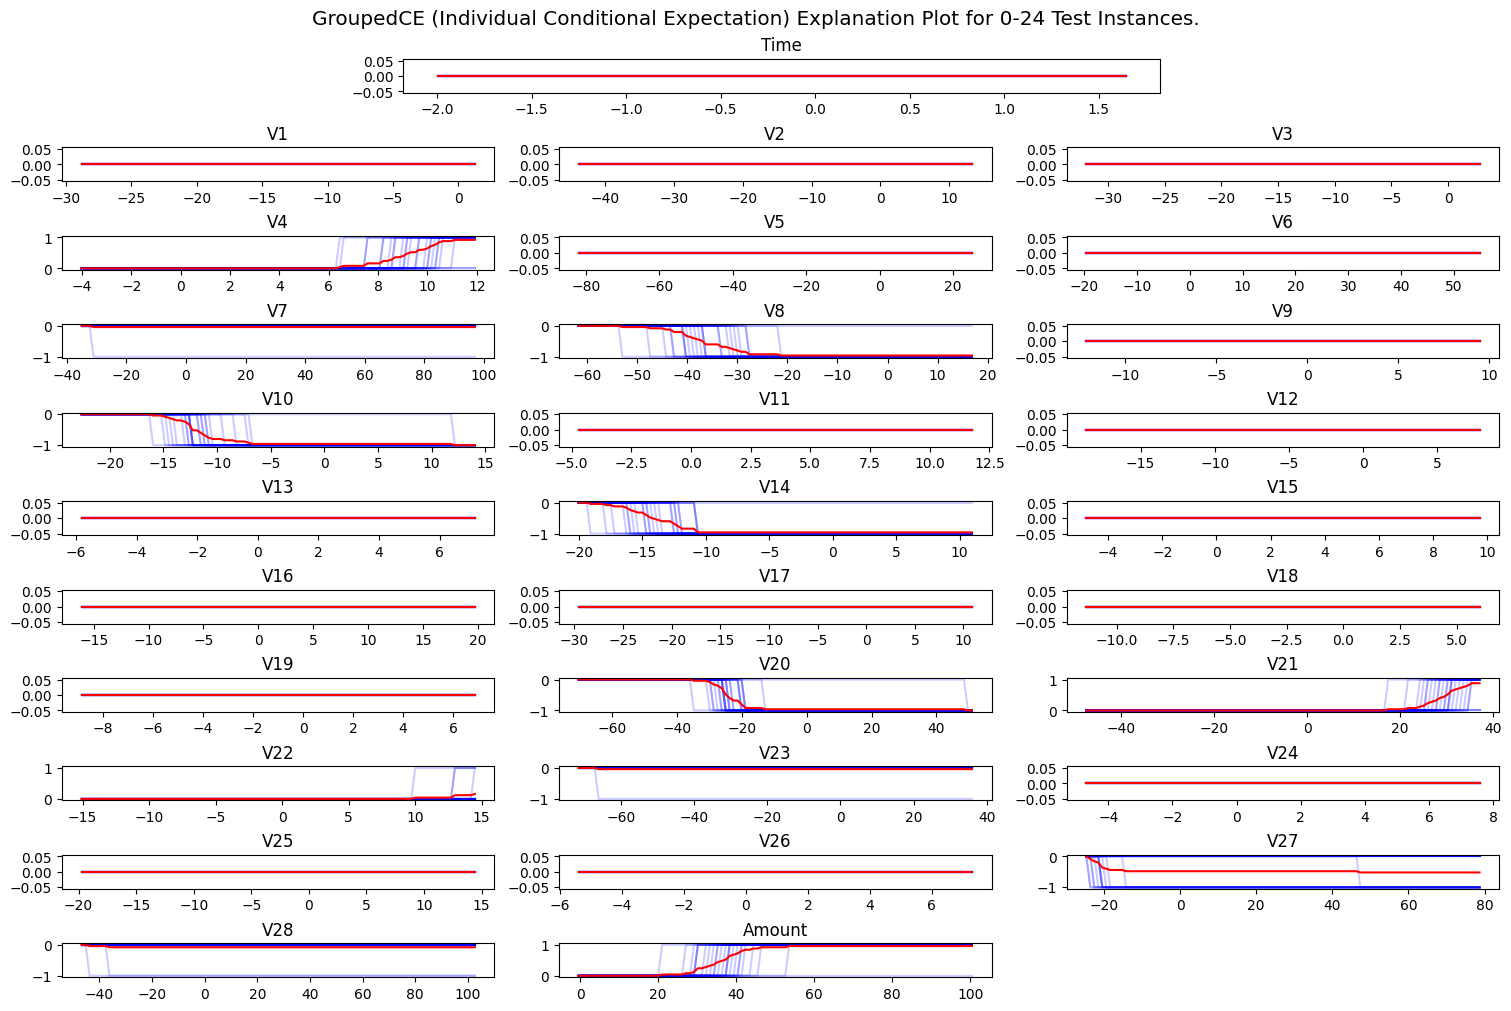

In [17]:
from aix360.algorithms.gce.gce import GroupedCEExplainer

n_test_samples = 25 # number of instances to explain
n_samples = 100 # number of samples to generate for selected feature

ice_explanations = {}
for i, feature_col in enumerate(predictors):
    ice_explainer = GroupedCEExplainer(model=lr.predict,
                                       data=X_train, 
                                       feature_names=predictors,
                                         n_samples=n_samples,
                                         features_selected=[feature_col],
                                        random_seed=22
                                  )
    ice_explanations[feature_col] = []
    for i in range(n_test_samples):
        ice_explanations[feature_col].append(ice_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:]))

plot_ice_explanation(ice_explanations, title="GroupedCE (Individual Conditional Expectation) Explanation Plot for {}-{} Test Instances.".format(0, n_test_samples-1))

  0%|          | 0/10 [00:00<?, ?it/s]/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2243: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2244: RuntimeWarning: invalid value encountered in true_divide
  + residuals_sum_squares / self.noise_variance_
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2243: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2244: RuntimeWarning: invalid value encountered in true_divide
  + residuals_sum_squares / self.noise_variance_
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle

Considering Top 4 features according to SHAP: ['Amount', 'V28', 'V1', 'V2']


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fit

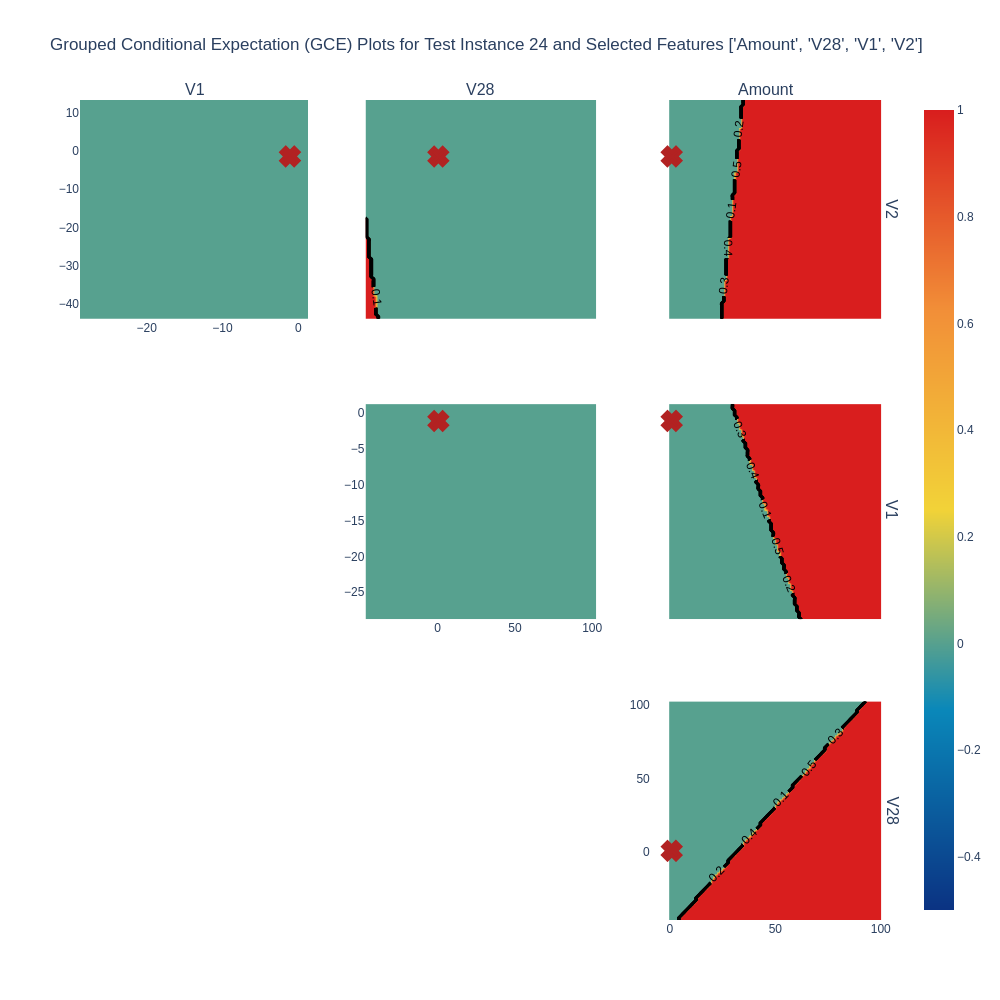

In [18]:
n_samples = 100
top_k_features = 4

# initialization
groupedce_explainer = GroupedCEExplainer(model=lr.predict,
                                         data=X_train, 
                                         feature_names=predictors,
                                         n_samples=n_samples,
                                         top_k_features=top_k_features,
                                        random_seed=22)
# compute explanation
groupedce_explanation = groupedce_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:])
title="Grouped Conditional Expectation (GCE) Plots for Test Instance {} and Selected Features {}".format(i, groupedce_explanation['selected_features'])

from IPython.display import Image
fig = plot_gce_explanation(groupedce_explanation, title=title)
dataset_plot_bytes = fig.to_image(format="png", width=1000, height=1000)
Image(dataset_plot_bytes)

### Random Forest

In [19]:
from aix360.algorithms.shap import KernelExplainer
idx = np.random.randint(X_train.shape[0],size=10000)
shapexplainer = KernelExplainer(clf.predict_proba, X_train.iloc[idx,:])
print(type(shapexplainer))

# aix360 style for explaining input instances
shap_values = shapexplainer.explain_instance(X_test.iloc[0,:])
for _ in zip(X_test.columns,shap_values[:,0]):
    print(_)

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<class 'aix360.algorithms.shap.shap_wrapper.KernelExplainer'>
('Time', 0.0)
('V1', 0.0)
('V2', -0.009612477103678557)
('V3', -0.03499733151496592)
('V4', -0.059959611190372235)
('V5', -0.0007884443646929101)
('V6', 0.0)
('V7', -0.04044767293547131)
('V8', 0.0)
('V9', -0.04689079318277541)
('V10', -0.06872590799705687)
('V11', -0.09909106817326736)
('V12', -0.16116901642460899)
('V13', 0.0)
('V14', -0.2015513773066645)
('V15', 0.0)
('V16', -0.08099545135047297)
('V17', -0.11983657286670826)
('V18', -0.046205178128154875)
('V19', 0.0)
('V20', -0.0014603540274479403)
('V21', -0.004982327130955355)
('V22', 0.0)
('V23', 0.0)
('V24', -0.0028720051131967124)
('V25', -0.003560344885310535)
('V26', 0.0)
('V27', 0.0)
('V28', 0.0)
('Amount', -0.005152066304105141)


In [20]:
from aix360.algorithms.lime import LimeTabularExplainer
limeexplainer = LimeTabularExplainer(X_train.iloc[idx,:].values)
explanattion = limeexplainer.explain_instance(X_test.iloc[0,:].values,clf.predict_proba)
print ('Explanation for class 0')
print ('\n'.join(map(str, explanattion.as_list())))

Explanation for class 0
('4 > 0.53', 0.004487783809710732)
('14 <= -0.44', 0.0037341556985911357)
('20 <= -0.28', 0.0030032596281280486)
('10 <= -0.51', 0.002956916518490341)
('29 > -0.04', 0.0028546024691572247)
('2 > 0.48', 0.002848360816503427)
('28 <= -0.16', 0.002583992989086004)
('23 <= -0.26', 0.0023344236334562544)
('0 <= -0.85', 0.002237060993579754)
('9 <= -0.59', 0.0022250379403792003)


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



NN Contrastive

In [21]:
neighbors = 3
explainer_with_model = NearestNeighborContrastiveExplainer(model=clf.predict,
                                              embedding_dim=embedding_dim,
                                              layers_config=layers_config,
                                              neighbors=neighbors)

history = explainer_with_model.fit(
    X_train,
    epochs=epochs,
    numeric_scaling=None,
    random_seed=random_seed,
)

p_str = f'Epochs: {epochs}'
for key in history.history:
    p_str = f'{p_str}\t{key}: {history.history[key][-1]:.4f}'
print(p_str)

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Epochs: 500	loss: 0.8322


In [22]:
# find nearest benign contrastive
explainer_with_model.set_exemplars(malignant_exemplars)
nearest_benign_contrastive = explainer_with_model.explain_instance(sample_malignant_cell)
nearest_benign_contrastive[0]["neighbors"][0]

delta = np.array(nearest_benign_contrastive[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(predictors)), predictors,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest benign contrastive', fontsize='x-large', fontweight='bold')
plt.show()

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



1/1 [==============================] - 0s 56ms/step


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

/tmp/ipykernel_689653/2317206152.py:17: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/tmp/ipykernel_689653/2317206152.py:17: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/tmp/ipykernel_689653/2317206152.py:17: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a fu

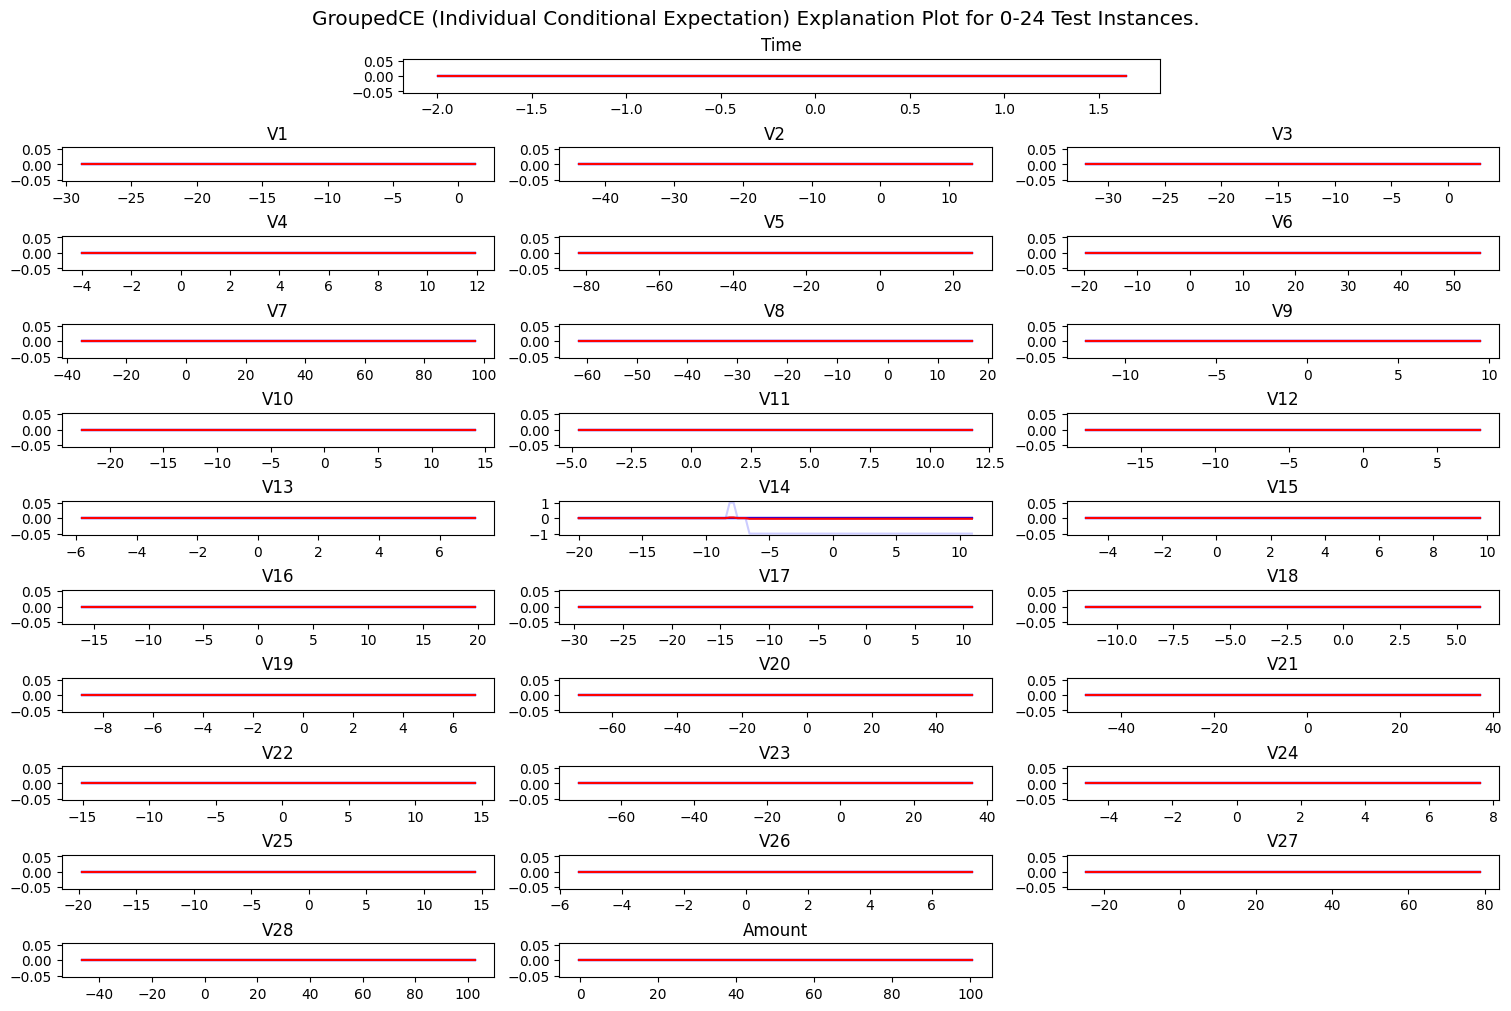

In [23]:
from aix360.algorithms.gce.gce import GroupedCEExplainer

n_test_samples = 25 # number of instances to explain
n_samples = 100 # number of samples to generate for selected feature

ice_explanations = {}
for i, feature_col in enumerate(predictors):
    ice_explainer = GroupedCEExplainer(model=clf.predict,
                                       data=X_train, 
                                       feature_names=predictors,
                                         n_samples=n_samples,
                                         features_selected=[feature_col],
                                        random_seed=22
                                  )
    ice_explanations[feature_col] = []
    for i in range(n_test_samples):
        ice_explanations[feature_col].append(ice_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:]))

plot_ice_explanation(ice_explanations, title="GroupedCE (Individual Conditional Expectation) Explanation Plot for {}-{} Test Instances.".format(0, n_test_samples-1))

  0%|          | 0/10 [00:00<?, ?it/s]/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2243: RuntimeWarning:

divide by zero encountered in log

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2244: RuntimeWarning:

invalid value encountered in true_divide

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2243: RuntimeWarning:

divide by zero encountered in log

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2244: RuntimeWarning:

invalid value encountered in true_divide

 20%|██        | 2/10 [00:00<00:00, 15.41it/s]/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:2243: RuntimeWarning:

divide by zero encountered in log

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_lea

Considering Top 4 features according to SHAP: ['Amount', 'V28', 'V1', 'V2']


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



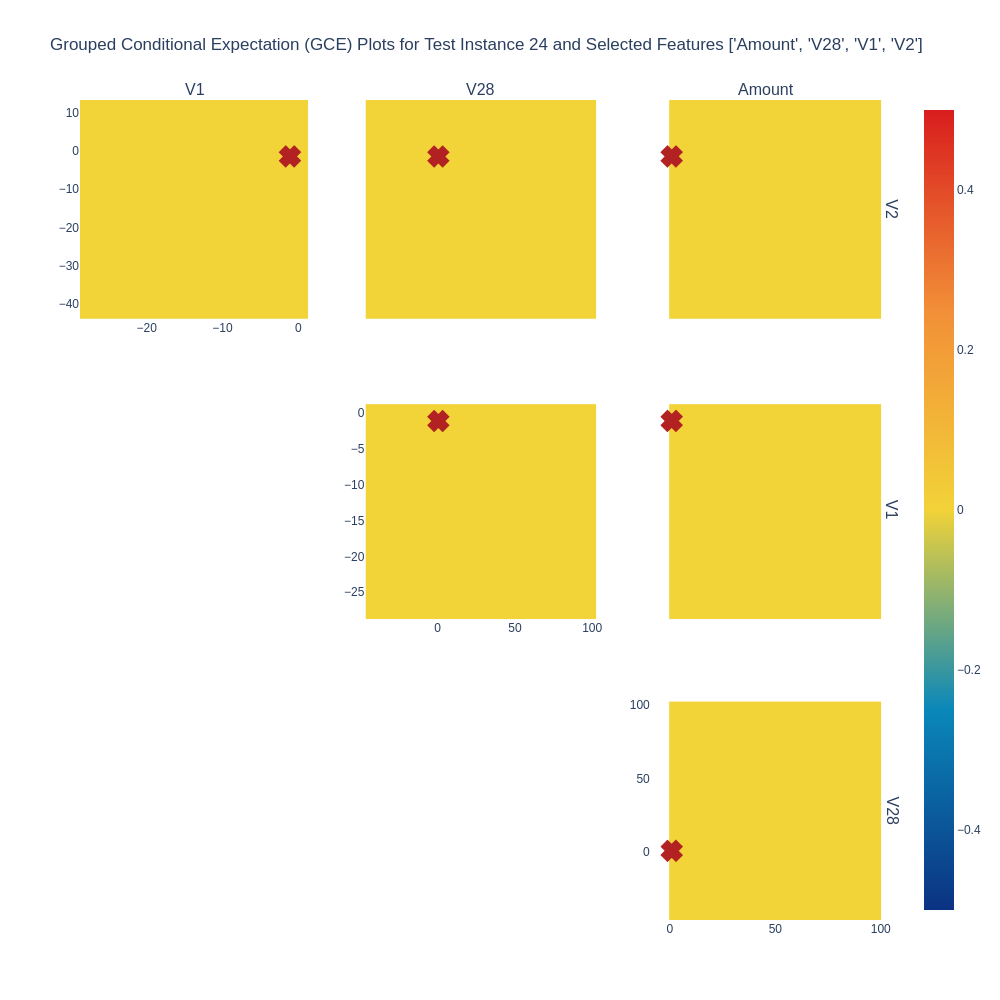

In [24]:
n_samples = 100
top_k_features = 4

# initialization
groupedce_explainer = GroupedCEExplainer(model=clf.predict,
                                         data=X_train, 
                                         feature_names=predictors,
                                         n_samples=n_samples,
                                         top_k_features=top_k_features,
                                        random_seed=22)
# compute explanation
groupedce_explanation = groupedce_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:])
title="Grouped Conditional Expectation (GCE) Plots for Test Instance {} and Selected Features {}".format(i, groupedce_explanation['selected_features'])

from IPython.display import Image
fig = plot_gce_explanation(groupedce_explanation, title=title)
dataset_plot_bytes = fig.to_image(format="png", width=1000, height=1000)
Image(dataset_plot_bytes)

### MLP

In [26]:
from aix360.algorithms.shap import KernelExplainer
idx = np.random.randint(X_train.shape[0],size=10000)
shapexplainer = KernelExplainer(model, X_train.iloc[idx,:])
print(type(shapexplainer))

# aix360 style for explaining input instances
shap_values = shapexplainer.explain_instance(X_test.iloc[0,:])
for _ in zip(X_test.columns,shap_values[:,0]):
    print(_)

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<class 'aix360.algorithms.shap.shap_wrapper.KernelExplainer'>
('Time', 0.007164693688997815)
('V1', 0.007339415742015924)
('V2', -0.008376881104397771)
('V3', 0.06363920856551497)
('V4', 0.09366867077382904)
('V5', -0.035771018318871056)
('V6', 0.007293514164629337)
('V7', 0.061436566922762115)
('V8', -0.023131067312777295)
('V9', 0.023093995042908728)
('V10', 0.12414226630803106)
('V11', 0.030901510115948088)
('V12', 0.15228919807159286)
('V13', 0.0)
('V14', 0.2404806392883716)
('V15', 0.0038685450795036594)
('V16', 0.06419040565382696)
('V17', 0.11281925142186362)
('V18', 0.007099034831313761)
('V19', 0.0)
('V20', 0.0)
('V21', 0.0030836915991313977)
('V22', 0.0)
('V23', 0.004492947099283894)
('V24', -0.006498888715357117)
('V25', 0.0)
('V26', 0.0)
('V27', -0.015233967484141495)
('V28', -0.012434599567941499)
('Amount', 0.009609341621398926)


LIME does not support TF

In [27]:
from aix360.algorithms.lime import LimeTabularExplainer
limeexplainer = LimeTabularExplainer(X_train.iloc[idx,:].values)
explanattion = limeexplainer.explain_instance(X_test.iloc[0,:].values,model)
print ('Explanation for class 0')
print ('\n'.join(map(str, explanattion.as_list())))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'sum'

NN Contrastive

In [28]:
neighbors = 3
explainer_with_model = NearestNeighborContrastiveExplainer(model=model,
                                              embedding_dim=embedding_dim,
                                              layers_config=layers_config,
                                              neighbors=neighbors)

history = explainer_with_model.fit(
    X_train,
    epochs=epochs,
    numeric_scaling=None,
    random_seed=random_seed,
)

p_str = f'Epochs: {epochs}'
for key in history.history:
    p_str = f'{p_str}\t{key}: {history.history[key][-1]:.4f}'
print(p_str)

Epochs: 500	loss: 0.8197


In [ ]:
# find nearest benign contrastive
explainer_with_model.set_exemplars(malignant_exemplars)
nearest_benign_contrastive = explainer_with_model.explain_instance(sample_malignant_cell)
nearest_benign_contrastive[0]["neighbors"][0]

delta = np.array(nearest_benign_contrastive[0]["neighbors"][0]) - np.array(sample_malignant_cell)

plot_matrix(delta,vmin=-1*np.max(np.abs(delta)), vmax=np.max(np.abs(delta)), rotation = 90)
plt.xticks(np.arange(len(predictors)), predictors,rotation = 90, fontsize='large')
plt.yticks([])
plt.tight_layout()
plt.title('delta between the selected malignant cell and the nearest benign contrastive', fontsize='x-large', fontweight='bold')
plt.show()

1/1 [==============================] - 0s 56ms/step


/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


IndexError: list index out of range

/tmp/ipykernel_689653/2245622485.py:17: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



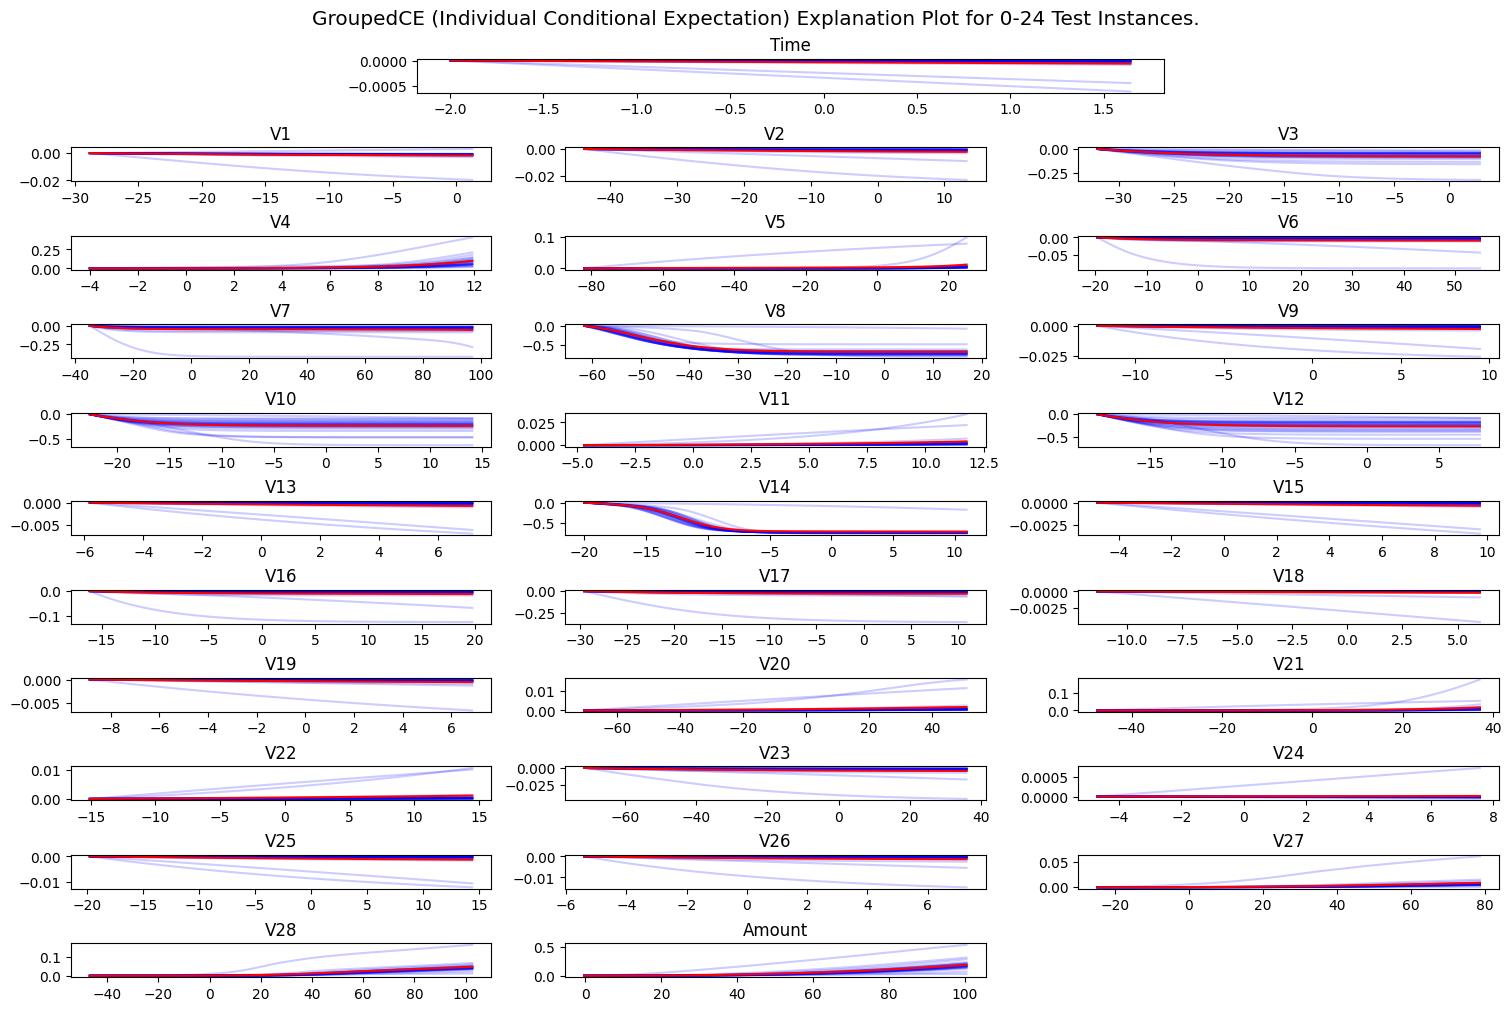

In [30]:
from aix360.algorithms.gce.gce import GroupedCEExplainer

n_test_samples = 25 # number of instances to explain
n_samples = 100 # number of samples to generate for selected feature

ice_explanations = {}
for i, feature_col in enumerate(predictors):
    ice_explainer = GroupedCEExplainer(model=model,
                                       data=X_train, 
                                       feature_names=predictors,
                                         n_samples=n_samples,
                                         features_selected=[feature_col],
                                        random_seed=22
                                  )
    ice_explanations[feature_col] = []
    for i in range(n_test_samples):
        ice_explanations[feature_col].append(ice_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:]))

plot_ice_explanation(ice_explanations, title="GroupedCE (Individual Conditional Expectation) Explanation Plot for {}-{} Test Instances.".format(0, n_test_samples-1))

In [34]:
n_samples = 100
top_k_features = 4

# initialization
groupedce_explainer = GroupedCEExplainer(model=model,
                                         data=X_train, 
                                         feature_names=predictors,
                                         n_samples=n_samples,
                                         top_k_features=top_k_features,
                                        random_seed=22)
# compute explanation
groupedce_explanation = groupedce_explainer.explain_instance(instance=X_test.iloc[i, :][np.newaxis,:])
title="Grouped Conditional Expectation (GCE) Plots for Test Instance {} and Selected Features {}".format(i, groupedce_explanation['selected_features'])

from IPython.display import Image
fig = plot_gce_explanation(groupedce_explanation, title=title)
dataset_plot_bytes = fig.to_image(format="png", width=1000, height=1000)
Image(dataset_plot_bytes)

  0%|          | 0/10 [00:00<?, ?it/s]/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:679: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.593e-06, previous alpha=2.304e-07, with an active set of 25 regressors.

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/shap/explainers/_kernel.py:707: UserWarning:

Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.

100%|██████████| 10/10 [00:00<00:00, 36.26it/s]
/tmp/ipykernel_689653/1788062830.py:12: FutureWarning:

Support for multi-dimension

Considering Top 4 features according to SHAP: ['Time']


KeyError: 'selected_features'